In [3]:
# Platypus (MOEA)
from platypus import NSGAII, Problem, Real

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import math
from numpy import *
from mpl_toolkits import mplot3d


#Import non-linear equation solver
from scipy.optimize import fsolve

#Import weather from MesoWest, In-active weather files are commented out.  To run a different location un-comment the desired weather file
import pandas as pd
#weatherfile = pd.read_csv('Documents\SLC2017Meso.csv') #Cool Dry
weatherfile = pd.read_csv('Documents\Omaha2018Meso.csv') #Mixed Humid
#weatherfile=pd.read_csv('Documents\Houston2018Meso.csv') #Hot Humid
#weatherfile=pd.read_csv('Documents\Pheonix2018Meso.csv') #Dry Hot
#weatherfile=pd.read_csv('Documents\LasVegas2018Meso.csv') #Dry Hot
#weatherfile = pd.read_csv('Documents\Toronto2018Meso.csv')
# Accessed here https://mesowest.utah.edu/cgi-bin/droman/download_api2.cgi?stn=KU42&hour1=22&min1=01&timetype=LOCAL&unit=0&graph=0

#Variable Declarations
Cook_time=30

In [6]:
def Psych(DB_air_in,RH,p_total):

# Psychrometric properties for moist air
# provided dry bulb temperature (Celsius), relative humidity (#), and total atmospheric pressure (kPa)
# Equations are from ASHRAE Fundamentals, see notation for exact equation references

    #{Calculating air properties}#
    #{Coefficient values from ASHRAE fundamentals handbook section 1.12}#
    c1=-5.6745359e+03
    c2=6.3925247e+00
    c3=-9.6778430e-03
    c4=6.2215701e-07
    c5=2.0747825e-09
    c6=-9.4840240e-13
    c7=4.1635019e00
    c8=-5.8002206e+03
    c9=1.3914993e+00
    c10=-4.8640239e-02
    c11=4.1764768e-05
    c12=-1.4452093e-08
    c13=6.5459673e00
    T=DB_air_in+273.15

    if DB_air_in==0:
        pws=math.exp(c8/T+c9+c10*T+c11*T**2+c12*T**3+c13*math.log(T)) #{Pa saturation pressure, EQN 6}#
        pw=0.01*RH*pws #{partial pressure of water vapor Eqn 24}#
        W_in=0.621945*pw/(p_total-pw) #{humidity ratio Eqn 22}#
        Ws=0.621945*pws/(p_total-pws) #{moist air saturation ratio Eqn 23}#
        h_air_inlet=1.006*DB_air_in+W_in*(2501+1.86*DB_air_in) #{kj/kg, Eqn 32}#
    if DB_air_in>0:
        pws=math.exp(c8/T+c9+c10*T+c11*T**2+c12*T**3+c13*math.log(T)) #{Pa saturation pressure, EQN 6}#
        pw=0.01*RH*pws #{partial pressure of water vapor Eqn 24}#
        W_in=0.621945*pw/(p_total-pw) #{humidity ratio Eqn 22}#
        Ws=0.621945*pws/(p_total-pws) #{moist air saturation ratio Eqn 23}#
        h_air_inlet=1.006*DB_air_in+W_in*(2501+1.86*DB_air_in) #{kj/kg, Eqn 32}#
    if DB_air_in<0:
        pws=math.exp(c1/T+c2+c3*T+c4*T**2+c5*T**3+c6*T**4+c7*math.log(T)) #{Pa saturation pressure, EQN 5}#
        pw=0.01*RH*pws #{partial pressure of water vapor Eqn 24}#
        W_in=0.621945*pw/(p_total-pw) #{humidity ratio Eqn 22}#
        Ws=0.621945*pws/(p_total-pws) #{moist air saturation ratio Eqn 23}#
        h_air_inlet=1.006*DB_air_in+W_in*(2501+1.86*DB_air_in) #{kj/kg, Eqn 32}#

#Wet Bulb emperical equation from RH and DB: Wet-Bulb Temperature from
#Relative Humidity and Air Temperature, Roland Stull https://doi.org/10.1175/JAMC-D-11-0143.1
    WB_air_in=DB_air_in*math.atan(0.151977*(RH+8.313659)**0.5)+math.atan(DB_air_in+RH)-math.atan(RH-1.676331)+0.00391838*RH**(3/2)*math.atan(0.023101*RH)-4.686035

    enthalpy = h_air_inlet # Convert to kg
    hum_ratio = W_in*1000 #Converts to g/kg
    wetbulb = WB_air_in
    Psat = pws
   
    return enthalpy, hum_ratio, wetbulb, Psat

In [7]:
#Calculate RH
def RH_calc(W_kg,H,p_total):

# Psychrometric properties for moist air
# provided Humidity ration, Enthalpy and atmospheric pressure
# Solves for Relative Humidity
# Equations are from ASHRAE Fundamentals, see notation for exact equation references

    W=W_kg/1000 #convert to kg/kg
    #{Calculating air properties}#
    #{Coefficient values from ASHRAE fundamentals handbook section 1.12}#
    c1=-5.6745359e+03
    c2=6.3925247e+00
    c3=-9.6778430e-03
    c4=6.2215701e-07
    c5=2.0747825e-09
    c6=-9.4840240e-13
    c7=4.1635019e00
    c8=-5.8002206e+03
    c9=1.3914993e+00
    c10=-4.8640239e-02
    c11=4.1764768e-05
    c12=-1.4452093e-08
    c13=6.5459673e00
    DB_air_in=(H-W*2501)/(1.006+W*1.86)
    T=DB_air_in+273.15

    pws=math.exp(c8/T+c9+c10*T+c11*T**2+c12*T**3+c13*math.log(T)) #{Pa saturation pressure, EQN 6}#
    Ws=0.621945*pws/(p_total-pws) #{moist air saturation ratio Eqn 23}#
    pw=p_kPa*W/(0.62+W) #eqn. 22

    RH=(pw/(pws))*100 #Eqn 24
    
    return RH, DB_air_in

In [8]:
#Candy Moisture diffusion, Calculates moisture content of candy based on oven time
def Moisture_Diffusion(Oven_time):
    #Moisture diffusion rate is a fourth order polynomial fit to the chart developed by Sudharsa
    New_Moisture_content=21.7-0.863*Oven_time+(0.0591*Oven_time**2)-(2.16e-3*Oven_time**3)+(2.92e-05*Oven_time**4)
    return(New_Moisture_content)

In [9]:
#Create Recipe Database
d = {'Duration': pd.Series([30,6],index=['Heat','Cool']),
     'Temp_set_point':pd.Series([50,20],index=['Heat','Cool']),
     'RH_set_point':pd.Series([10,'NaN'],index=['Heat','Cool']),
     'Boards':pd.Series([5400,5400],index=['Heat','Cool']),
     'Starch_per_board':pd.Series([4275,5275],index=['Heat','Cool']),
     'Piece_candy_per_board':pd.Series([380,380],index=['Heat','Cool']),
     'Weight_candy_dry':pd.Series([2.125,2.125],index=['Heat','Cool']),
     'Starch_specific_heat':pd.Series([1.24,1.24],index=['Heat','Cool']),
     'Sugar_specific_heat':pd.Series([1.369,1.244],index=['Heat','Cool']),
     'Product DT':pd.Series([15,40],index=['Heat','Cool']),
    }

#Specific heat in kj/kg
#Mohos2017 - Starch Specific heat
#Sugar specific heat http://www.sugartech.com/heatcapacity/index.php
Recipe = pd.DataFrame(d)
print(Recipe)


      Duration  Temp_set_point RH_set_point  Boards  Starch_per_board  \
Heat        30              50           10    5400              4275   
Cool         6              20          NaN    5400              5275   

      Piece_candy_per_board  Weight_candy_dry  Starch_specific_heat  \
Heat                    380             2.125                  1.24   
Cool                    380             2.125                  1.24   

      Sugar_specific_heat  Product DT  
Heat                1.369          15  
Cool                1.244          40  


In [10]:
#Stove Recipe, #Input Time
def Stove(Time, m_dot_SA, Recipe, Cycle):
    #Define dry weight, and get Temp set-points
    Wd=Recipe.loc[Cycle,'Weight_candy_dry']*Recipe.loc[Cycle,'Piece_candy_per_board']*Recipe.loc[Cycle,'Boards'] #Candy weight dry
    #Heating Set_Points
    TDB_SSP=Recipe.loc[Cycle,'Temp_set_point'] #C
    RH_SSP=Recipe.loc[Cycle,'RH_set_point'] #%RH
    
    if Cycle == 'Heat' and Time == 0:    #Sets initial moisture content
        Ww_old=Moisture_Diffusion(Time)
        H2O_load=0
    elif Cycle =='Heat':
        #Moisture Gain - Continue fixing this
        Mw_new=Moisture_Diffusion(Time) ##Mw_new = Wet Basis moisture content
        Mw_old=Moisture_Diffusion(Time-1)
        Ww_old=Mw_old*Wd/(1-Mw_old)
        Ww_New=Mw_new*Wd/(1-Mw_new) ##Ww = Weight of the water, https://engineering.purdue.edu/~abe305/moisture/html/page8.htm
        
        H2O_load=(Ww_old-Ww_New)*3 #kg water, the *3 is to convert from a 20 minute load to an hourly load
    else: 
        H2O_load=0
 
    #Thermal losses to surrounding
    #q_sensible=50 #Old Heat Loss
    Oven_length=16.000 #m
    Oven_width=3.000 #m
    Oven_height=4.800 #m
    Oven_Surface_Area=Oven_length*Oven_width+Oven_length*Oven_height*2
    Oven_amb_DT=TDB_SSP-21.1
    Oven_Wall_U_value=2 #W/m^2k From Carbon Trust
    q_sensible=Oven_Wall_U_value*Oven_Surface_Area*Oven_amb_DT/1000
    #Thermal load of product
    q_product=(Recipe.loc[Cycle,'Product DT']*Wd*Recipe.loc[Cycle,'Sugar_specific_heat']/1000+
               Recipe.loc[Cycle,'Product DT']*Recipe.loc[Cycle,'Boards']*Recipe.loc[Cycle,'Starch_per_board']*Recipe.loc[Cycle,'Starch_specific_heat']
               /(Recipe.loc[Cycle,'Duration']*3600*1000))
    #Heat Return air conditions
    if Cycle == 'Heat':
        (H_RA,W_RA,T_WB_RA,P_SAT_RA)=Psych(TDB_SSP,RH_SSP,101325)
        #Required Humidity ratio to maintain set-point
        W_SA=(m_dot_SA*W_RA-H2O_load)/m_dot_SA
        #Supply air Enthalpy Req. to maintain oven temp
        H_SA=H_RA+(q_sensible+q_product)/m_dot_SA #kJ/kg
        #Cool Return air conditions
    if Cycle == 'Cool':
        (H_RA,W_RA,T_WB_RA,P_SAT_RA)=Psych(TDB_SSP,50,101325) #### Need to pass the humidity to this somehow
        #Supply air Enthalpy Req. to maintain oven temp
        H_SA=H_RA-q_product/m_dot_SA
        W_SA=0.002
    return(H2O_load, W_SA, W_RA, H_SA,H_RA, Wd, q_product)

In [11]:
#Economizer Function for Humidity
def Econ_hum(W_RA, W_OA, W_SA,H_RA,H_OA,H_SA,min_OA_Per, m_dot_SA):
    if W_OA >= W_RA: #If outdoor air humidity is greater than return air humidity bring in the minimum amount of Outdoor air
        m_dot_OA=0.1*m_dot_SA
    if W_OA <= W_SA: #Blend air streams so that W_mixed=W_SA
        m_dot_OA=m_dot_SA*(W_SA-W_RA)/(W_OA-W_RA)
    if W_OA < W_RA and W_OA > W_SA: #W_OA is less than W_RA but > W_SA so draw all outside air
        m_dot_OA=m_dot_SA
    m_dot_RA=m_dot_SA-m_dot_OA
    W_mixed=(m_dot_RA*W_RA+m_dot_OA*W_OA)/(m_dot_RA+m_dot_OA)
    H_mixed=(m_dot_RA*H_RA+m_dot_OA*H_OA)/(m_dot_RA+m_dot_OA)
    return(m_dot_RA,m_dot_OA,W_mixed,H_mixed)
    

In [12]:
#Economizer Function for Enthalpy
def Econ_enthalpy(W_RA, W_OA, W_SA,H_RA,H_OA,H_SA,min_OA_Per, m_dot_SA):
    if H_OA >= H_RA: #If outdoor air humidity is greater than return air humidity bring in the minimum amount of Outdoor air
        m_dot_OA=0.1*m_dot_SA
    if H_OA <= H_SA: #Blend air streams so that W_mixed=W_SA
        m_dot_OA=m_dot_SA*(H_SA-H_RA)/(H_OA-H_RA)
    if H_OA < H_RA and H_OA > H_SA: #W_OA is less than W_RA but > W_SA so draw all outside air
        m_dot_OA=m_dot_SA
    m_dot_RA=m_dot_SA-m_dot_OA
    H_mixed=(m_dot_RA*H_RA+m_dot_OA*H_OA)/(m_dot_RA+m_dot_OA)
    W_mixed=(m_dot_RA*W_RA+m_dot_OA*W_OA)/(m_dot_RA+m_dot_OA)
    return(m_dot_RA,m_dot_OA,W_mixed,H_mixed)

In [13]:
#Air Handler
def AHU(H_RA, W_RA, m_dot_RA, H_OA, W_OA, m_dot_OA, W_SA, H_SA,W_mixed,H_mixed):
    #Calculate Load on Air Handler
    #q_AHU=(m_dot_RA+m_dot_OA)*((H_mixed-H_SA)-(W_mixed-W_SA)*H_SA)
    q_AHU=(m_dot_RA+m_dot_OA)*((H_SA-H_mixed)) #kW
    return(q_AHU)

In [14]:
#Dehumidifier - Beccali Psychrometric Model 2004 Simplified models for the performance evaluation of desiccant
#wheel dehumidification

def Dehum_Psych(X_out, X_in, UR_in,h_in, h_reg_in,X_reg_in):
    #Variable definitions
    #UR = Relative humidity
    #in/out = process stream
    #X - g water / kg water
     
    X_reg_out=(X_in+X_reg_in)-X_out
    #fsolve to solve equations
    z=empty((6))
    def myFunction(z):
        Tout=z[0]
        UR_reg=z[1]
        h_out=z[2]
        h_reg=z[3]
        h_reg_out=z[4]
        UR_out=z[5]
        
        
        F=empty((6))
        F[0]=X_out-(math.exp(0.053*Tout)*(0.9428*UR_reg+0.0572*UR_in)-1.7976)/18.671 #equation 8
        F[1]=(UR_out*math.exp(0.053*Tout)-1.7976)/18671-(h_out-1.006*Tout)/(2501-1.805*Tout) #equation 9
        F[2]=UR_out-(0.9428*UR_reg+0.0572*UR_in) #equation 10
        F[3]=h_out-(0.1312*h_reg+0.8688*h_in) #equation 11
        F[4]=(h_in-h_out)-(h_reg-h_reg_out)
        F[5]=UR_reg-(18.6715*X_reg_in+1.7976)*math.exp(-0.053*((1000*h_reg-2501*X_reg_in)/(1.805*X_reg_in+1006))) #Energy Balance
        
        return F
    zGuess=array([30,28,40,48,30,10])
    z=fsolve(myFunction,zGuess)

    Tout=z[0]
    UR_reg=z[1]
    h_out=z[2]
    h_reg=z[3]
    h_reg_out=z[4]
    UR_out=z[5]
    q_dot_Dehum=(h_reg-h_reg_in) #kj/kg

    return(Tout, UR_reg, h_out, h_reg, UR_out, q_dot_Dehum)


In [15]:
# For loop to run through calculating outdoor conditions, Generate Stove load, Generate AHU load and Dehumidifier load
#Define this as a function (inputs=m_dot_SA, m_dot_DH, DH_set_point)
def Stove_Run(vars):
    #Define Results Database,'H20_Load':[]
    results = pd.DataFrame({'Date':[],'q_AHU':[],'H20_Load':[], 'Oven_counter':[], 'Cycle':[],'x':[],'Dry_Bulb':[]})
    q_AHU_annual=0
    q_Dehum_annual=0
    Oven_counter=0
    Total_Product=0
    Cycle='Heat'
    for x in range(0,12707): #Runs through a single Stove heat cycle, total cycle 25415
        #Assigns weather conditions at this instance of time
        RH_OA=weatherfile.loc[x,'RH']
        DB_OA=weatherfile.loc[x,'Dry_Bulb']
        p_kPa=weatherfile.loc[x,'Pressure']
        (H_OA,W_OA,T_WB_OA,P_SAT_OA)=Psych(DB_OA,RH_OA,p_kPa)
        
        
        Dry_Bulb=weatherfile.loc[x,'Dry_Bulb']
        #Define Cycle counter
        #Heating cycle lasts 30 hours, weather is incremented in 20 minutes
        Oven_counter=Oven_counter+1/3 # For SLC or US data(1/3)
        #Change oven cycle to cooling once Heat duration is exceeded
        if Cycle == 'Heat' and Oven_counter > Recipe.loc['Heat','Duration']:
            Cycle = 'Cool'
            Oven_counter=0
        #Change cycle back to heat
        if Cycle == 'Cool' and Oven_counter > Recipe.loc['Cool','Duration']:
            Cycle = 'Heat'
            Oven_counter=0
            Total_Product=Total_Product+Wd
    
        #Define Air Mass Flow Rate, Dehum Mass Flow Rate and Dehum set_point
        m_dot_SA = vars[0] #kg/s
        min_OA_Per = vars[1]
    
        #Call Stove
        (H2O_load, W_SA, W_RA, H_SA,H_RA, Wd, q_product)=Stove(Oven_counter, m_dot_SA*3600,Recipe,Cycle) #Stove accepts kg/hr
        
        m_dot_OA=m_dot_SA*min_OA_Per
        m_dot_RA=m_dot_SA-m_dot_OA
        if Cycle =='Heat':
            
            #Set the humidity ratio leaving the dehumidifier
            W_Dehum=(W_SA*m_dot_SA-W_RA*m_dot_RA)/(m_dot_OA)
            if W_Dehum < 0:
                Cost=(11225+m_dot_SA*13342)+(17706+39716*m_dot_OA-2199.2*m_dot_OA**2)
                return[q_AHU_annual, q_Dehum_annual,Cost],[W_Dehum]
            if W_OA > W_Dehum:
                Tout, UR_reg, h_out, h_reg, UR_out, q_dot_Dehum = Dehum_Psych(W_Dehum,W_OA,RH_OA,H_OA,38.6,7.291)            

                
                q_Dehum=q_dot_Dehum*m_dot_OA
                H_mixed=(m_dot_RA*H_RA+m_dot_OA*h_out)/(m_dot_RA+m_dot_OA)
                W_mixed=(m_dot_RA*W_RA+m_dot_OA*W_Dehum)/(m_dot_RA+m_dot_OA)
            #Calculate mix air properties
            if W_OA < W_Dehum:
                #Assign all dehumidifier variables 0
                q_Dehum=0
                Tout=0
                UR_reg=0
                h_out=0
                UR_out=0
                h_reg=0
                
                H_mixed=(m_dot_RA*H_RA+m_dot_OA*H_OA)/(m_dot_RA+m_dot_OA)
                W_mixed=(m_dot_RA*W_RA+m_dot_OA*W_OA)/(m_dot_RA+m_dot_OA)
                
            q_AHU=AHU(H_RA, W_RA, m_dot_RA, H_OA, W_OA, m_dot_OA, W_SA, H_SA,W_mixed,H_mixed)
            
          
        if Cycle =='Cool':
            (m_dot_RA,m_dot_OA,W_mixed,H_mixed)=Econ_enthalpy(W_RA, W_OA, W_SA,H_RA,H_OA,H_SA,min_OA_Per, m_dot_SA)
            q_Dehum=0 #No Dehumidification in cooling mode
            q_AHU=0

## To run energy model for a single solution set un-comment this code            
            
        #Write results to Database
        #results_time_step = pd.DataFrame({'Date':[weatherfile.loc[x,'Date_Time']],'q_AHU':[q_AHU],'H20_Load':[H2O_load],
                                      #'Oven_counter':[Oven_counter], 'Cycle':[Cycle],'x':[x],'Dry_Bulb':[Dry_Bulb],'q_Dehum':[q_Dehum],
                                        #'W_OA':[W_OA],'W_RA':[W_RA],'W_SA':[W_SA],'W_Dehum':[W_Dehum],'Tout':[Tout],'h_reg':[h_reg]})
        
        #results=results.append(results_time_step)
        q_AHU_annual+=q_AHU
        q_Dehum_annual+=q_Dehum
    #Define first cost
    Cost=(11225+m_dot_SA*13342)+(17706+39716*m_dot_OA-2199.2*m_dot_OA**2)
    return[q_AHU_annual, q_Dehum_annual,Cost],[W_Dehum]
    ##Un-comment this code to run as a single solution set
    #return(results)


In [64]:
##Output code for running at a single solution set
#vars=[4.02178753049017,0.23919770436011] #10% OA for Pinco, 
#stove_results=Stove_Run(vars)

In [65]:
##Output code for running at a single solution set

print(stove_results)
stove_results.to_csv('Omaha.csv')

   Cycle                  Date  Dry_Bulb      H20_Load  Oven_counter  \
0   Heat  01-01-2017 23:15 MST      -1.7  26568.766483      0.333333   
0   Heat  01-01-2017 23:35 MST      -1.0  26099.027315      0.666667   
0   Heat  01-01-2017 23:55 MST      -0.5  25604.564663      1.000000   
0   Heat  01-02-2017 00:15 MST      -0.3  25087.508525      1.333333   
0   Heat  01-02-2017 00:35 MST       0.0  24550.101134      1.666667   
0   Heat  01-02-2017 00:55 MST       0.4  23994.678223      2.000000   
0   Heat  01-02-2017 01:15 MST       1.2  23423.649538      2.333333   
0   Heat  01-02-2017 01:35 MST       2.2  22839.478895      2.666667   
0   Heat  01-02-2017 01:55 MST       2.7  22244.664076      3.000000   
0   Heat  01-02-2017 02:15 MST       3.0  21641.716851      3.333333   
0   Heat  01-02-2017 02:35 MST       3.6  21033.143411      3.666667   
0   Heat  01-02-2017 02:55 MST       3.6  20421.425463      4.000000   
0   Heat  01-02-2017 03:15 MST       3.8  19809.002226      4.33

In [16]:
#MOEA

#Decision variables = m_dot_SA, min_OA_per
#Objective: Minimize: q_AHU, q_Dehum, #Fan_Power,  Need to define a power function for the fans

#Question - How do I let the optimizer now that I want the objectives to be minimized?
#Answer - Python assumes minimize is the goal.  To change direction use problem.directions[:] = Problem.MAXIMIZE

#Define problem type
#problem=Problem(2,2)   #3 decision variables, 2 objectives, No constraint
problem=Problem(2,3, 1)   #3 decision variables, 3 objectives, One constraint


#Define the type of decision variables
problem.types[0] = Real(2, 10) #m_dot_SA, Adjust so that ACH is greater than 4 Check Carbon Trust
problem.types[1] = Real(0.08,0.4) #min_OA_Per, Varies minimum outdoor air
#problem.types[2] = Real(0.002857, 0.02857) #DH_set_pointkgWater/kgDryAir
problem.directions[0] = Problem.MINIMIZE #Air Handler energy use
problem.directions[1] = Problem.MINIMIZE #Dehumidifier energy use
problem.directions[2] = Problem.MINIMIZE #First cost for airhandler and dehumidifier
#problem.directions[2] = Problem.MINIMIZE 

#Define Constraints
problem.constraints[0] = ">0" #Dehumidifier set-point must be greater than 0

#Define the function
problem.function=Stove_Run  #Need to update stove so that it is a function and returns the objective variables
#This code runs the problem
algorithm = NSGAII(problem) #Defines that NSGAII will be used
algorithm.run(10) #Defines the population space is 10,000


C:\Users\Legorburu\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Legorburu\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


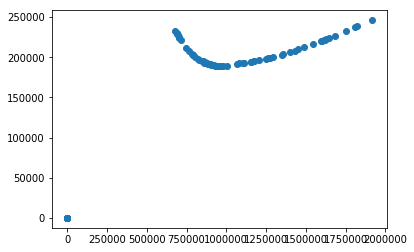

In [17]:
##Example plot code for 2d plot

plt.scatter([s.objectives[0] for s in algorithm.result],
            [s.objectives[1] for s in algorithm.result])


In [72]:
for solution in algorithm.result:
    print(solution)

Solution[2.4576886933923707,0.3917623656317159|671381.3838498216,235507.37686278115,97922.48666824374|0]
Solution[4.187649530452014,0.22975156945049874|671036.4021267596,235618.37154623226,120978.40008600782|0]
Solution[4.099732428278991,0.3968331893220614|988460.6119716712,188814.08425661622,142423.0621385022|0]
Solution[9.999827707890269,0.15539803403347804|954428.6924012367,188870.7281984405,218754.95523142253|0]
Solution[7.929222377915061,0.20352767845941178|982354.4957090927,188765.0208201682,193089.407423319|0]
Solution[6.968247101929509,0.1394939526293615|675829.4556210606,234360.58469637128,158428.53993659676|0]
Solution[5.986781613743705,0.16623711923548215|687070.3461975454,231230.03568810644,146154.76023244532|0]
Solution[9.392288796387145,0.1591263623405877|926547.7918395359,189640.48389716411,208688.5128072322|0]
Solution[8.881157536550875,0.12560206365007212|745851.7054872,212022.08523455422,188989.76034918087|0]
Solution[9.857343124805167,0.10246593602155005|694344.20644